In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import scipy.sparse.linalg as sla
from scipy.linalg import eig
from tqdm import tqdm
import pickle 


In [6]:
#define z and w 

def z(k,t,e,t3):
    z=-t*(1+e)-t*(1-e)*np.exp(-1j*k)+t3*np.exp(1j*k)
    return(z)
#removed d3 dependence because it's fixed to 0
def w(k,d,e):
    w=-d*(1+e)+d*(1-e)*np.exp(-1j*k)
    return(w)

In [7]:
#Define Hamiltonian

def H(k,t,e,t3,d,m):
    
    
    H = np.zeros((4,4), dtype=complex)
    H[0,0]=-m
    H[0,1]=z(k,t,e,t3)
    H[0,2]=0
    H[0,3]=w(k,d,e)
    H[1,0]=np.conj(z(k,t,e,t3))
    H[1,1]=-m
    H[1,2]=-np.conj(w(k,d,e))
    H[1,3]=0
    H[2,0]=0
    H[2,1]=-w(k,d,e)
    H[2,2]=m
    H[2,3]=-z(k,t,e,t3)
    H[3,0]=np.conj(w(k,d,e))
    H[3,1]=0
    H[3,2]=-np.conj(z(k,t,e,t3))
    H[3,3]=m
    
    return(H)

def magical(k,t,e,t3,d,m):
    #magic Unitary
    #U = np.array([[1,1],[1j,-1j]], dtype='complex128')
    #U = np.kron(U,np.eye(2))
    #magic = (1/2)*(U@U)
    #our one doesn't work we use the rotation found in literature
    U = np.array([[1,1],[-1j,1j]], dtype='complex128')
    magic = (1/np.sqrt(2))*np.kron(U,np.eye(2))
    return (magic@H(k,t,e,t3,d,m)@magic.conj().T)[:2, 2:]

id=np.array([[1,0],[0,1]])
sigma_x=np.array([[0,1],[1,0]])
sigma_z=np.array([[1,0],[0,-1]])

In [8]:
np.allclose((magic@H(1,1,1,1,1,1)@magic.conj().T)[:2, 2:],(magic@H(1,1,1,1,1,1)@magic.conj().T)[2:, :2].conj().T)

NameError: name 'magic' is not defined

In [22]:
#symmetry operator
id=np.array([[1,0],[0,1]])
sigma_x=np.array([[0,1],[1,0]])

C2= np.kron(sigma_x,id)
sigma_z=np.array([[1,0],[0,-1]])
C2idsig= np.kron(id,sigma_x)
sigma_z=np.array([[1,0],[0,-1]])

C1= np.kron(id,sigma_z)
print(C2)

[[0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]]


In [11]:
#check commutation, we discover that differently from what they say in paper it's actually sigma_x\bigo\id
C2@np.conj(H(1,1,1,1,1,1))@C2+H(-1,1,1,1,1,1)

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [25]:

#original formula on H(k,t,e,t3,d,m), looping over e and t3

#parameters definition H(k,1,e,t3,0.2,0)

par_res=0.1
k_res=0.12
e_range = np.arange(-.99, 0.99, par_res)
t_range = np.arange(-3, 3, par_res)
k_range = np.arange(-np.pi, np.pi, k_res)
d=0.2

A_kit1 = np.zeros((len(e_range),len(t_range)), dtype='c16')

for m,e in enumerate(tqdm(e_range)):
    
    for n,t3 in enumerate(t_range):
        
        v=np.zeros(len(k_range),dtype='c16')
        
        for i,k in enumerate(k_range):
            
            
            inv = (np.linalg.inv(H(k,1,e,t3,d,0)))
            der = (1/(2*k_res))*(H(k+(k_res),1,e,t3,d,0)-H(k-(k_res),1,e,t3,d,0))
            temp = (C2@inv@der)
            v[i]= np.trace(temp)
           
        v_tot=(k_res)*(1/(4*np.pi*1j))*np.sum(v,axis=0) 
   
        A_kit1[m,n]=v_tot

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.34it/s]


In [26]:
import scipy
from scipy.integrate import quad
def integrand(k,t,e,t3,d,m):
    k_res=0.001
    inv = (np.linalg.inv(magical(k,t,e,t3,d,m)))
    der = (1/(2*k_res))*(magical(k+k_res,t,e,t3,d,m)-magical(k-k_res,t,e,t3,d,m))
    temp = (inv@der)
    return np.trace(temp)

def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = quad(real_func, a, b)
    imag_integral = quad(imag_func, a, b)
    return((real_integral[0] + 1j*imag_integral[0]))


In [17]:
#WORKING ONE -variation with integrator and chiral index method 


#original formula on H(k,t,e,t3,d,m), looping over e and t3

#parameters definition H(k,1,e,t3,0.2,0)

par_res=0.1
k_res=0.1
e_range = np.arange(-.99, 0.99, par_res)
t_range = np.arange(-3, 3, par_res)
k_range = np.arange(-np.pi, np.pi, k_res)
d=0.2

A_kit = np.zeros((len(e_range),len(t_range)), dtype='c16')

for m,e in enumerate(tqdm(e_range)):
    
    for n,t3 in enumerate(t_range):
        
        v_tot=complex_quadrature(lambda k: integrand(k,1,e,t3,d,0),-np.pi,np.pi)
           
        v_tot=(1/(2*np.pi*1j))*v_tot 
   
        A_kit[m,n]=v_tot

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [01:07<00:00,  3.39s/it]


Text(0.5, 0, '$\\frac{t_{3}}{t}$')

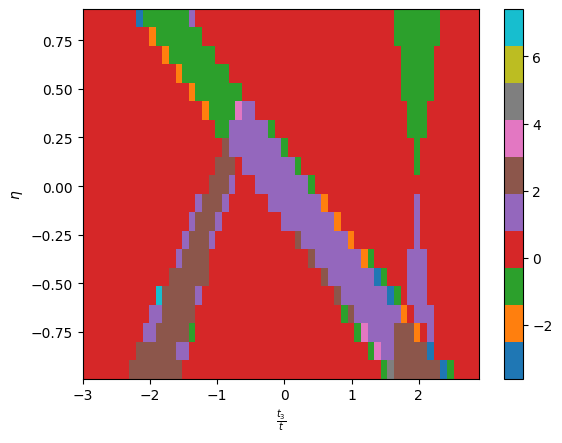

In [27]:
#boxplot, resolution is bad and parameter resolution is not good also 
x,y = t_range,e_range          #Transposed for easier unpacking
grid=np.real(np.flipud(A_kit1))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()), aspect='auto',
           interpolation='nearest',cmap='tab10')
#,vmin=,vmax=
fig.colorbar(cax)
#pixel_plot = plt.imshow(
#  np.real(data), cmap='twilight', interpolation='none')
plt.ylabel(r'$\eta$')  
plt.xlabel(r'$\frac{t_{3}}{t}$')

  

In [86]:
#check A
F = A_kit[A_kit.real>1e-10]
print(np.shape(A_kit),A_kit[:,25])

(10, 30) [ 2.0026061 +0.j  0.97362788+0.j  0.99914123+0.j  0.99966904+0.j
  0.99982512+0.j -0.99968798-0.j -1.00006817-0.j -1.00004551-0.j
 -1.00003062-0.j -1.00002026-0.j]


Text(0.5, 0, '$\\frac{t_{3}}{t}$')

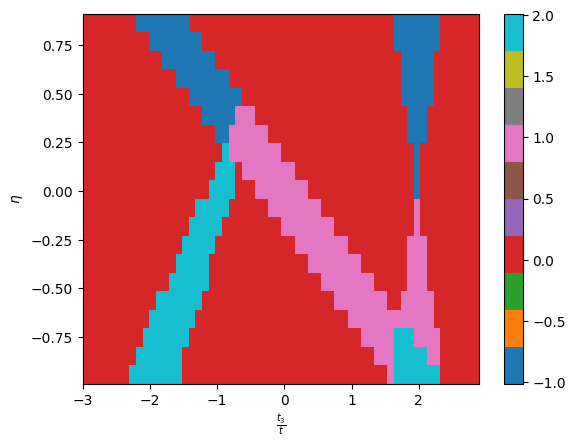

In [88]:
#boxplot, resolution is bad and parameter resolution is not good also 
x,y = t_range,e_range          #Transposed for easier unpacking
grid=np.real(np.flipud(A_kit))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()), aspect='auto',
           interpolation='nearest',cmap='tab10')
#,vmin=,vmax=
fig.colorbar(cax)
#pixel_plot = plt.imshow(
#  np.real(data), cmap='twilight', interpolation='none')
plt.ylabel(r'$\eta$')  
plt.xlabel(r'$\frac{t_{3}}{t}$')

  

Text(0.5, 0, '$\\frac{t_{3}}{t}$')

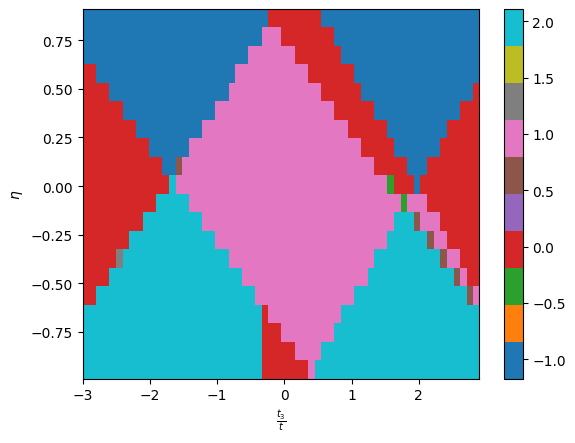

In [14]:
#boxplot, resolution is bad and parameter resolution is not good also 
x,y = t_range,e_range          #Transposed for easier unpacking
grid=np.real(np.flipud(A_kit))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()), aspect='auto',
           interpolation='nearest',cmap='tab10')
#,vmin=,vmax=
fig.colorbar(cax)
#pixel_plot = plt.imshow(
#  np.real(data), cmap='twilight', interpolation='none')
plt.ylabel(r'$\eta$')  
plt.xlabel(r'$\frac{t_{3}}{t}$')

  

In [15]:
print(A_test[A_test<1])

[-1.07561844e+00-0.j -1.60694406e+00-0.j -2.59273891e+00-0.j
 -4.71283846e+00-0.j -1.05862315e+01-0.j -3.87756255e+01-0.j
 -1.79751166e+03-0.j -5.80458148e+01-0.j -1.30518812e+01-0.j
 -5.46131217e+00-0.j -2.92393107e+00-0.j -1.79173923e+00-0.j
 -1.19788306e+00-0.j -8.52537115e-01-0.j -6.37023356e-01-0.j
 -4.95692167e-01-0.j -3.99797089e-01-0.j -3.33390433e-01-0.j
 -2.87151282e-01-0.j -2.55441483e-01-0.j -2.34807928e-01-0.j
 -2.23188091e-01-0.j -2.19486044e-01-0.j -2.23364152e-01-0.j
 -2.35181559e-01-0.j -2.56060200e-01-0.j -2.88099169e-01-0.j
 -3.34808692e-01-0.j -4.01923206e-01-0.j -4.98936905e-01-0.j
 -6.42130898e-01-0.j -8.60945046e-01-0.j -1.21261842e+00-0.j
 -1.81997413e+00-0.j -2.98579680e+00-0.j -5.63037870e+00-0.j
 -1.37598106e+01-0.j -6.74178800e+01-0.j -1.64699182e+03-0.j
 -1.72925964e+03-0.j -4.23251912e+01-0.j -1.11314652e+01-0.j
 -4.88699798e+00-0.j -2.66905604e+00-0.j -1.64686047e+00-0.j
 -7.00495835e-01-0.j -9.84864346e-01-0.j -1.45701360e+00-0.j
 -2.31521953e+00-0.j -4.

In [89]:
#saving data
with open('A_Kitaev_normalmethod_k_res='+str(k_res)+' par_res='+str(par_res)+'.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(A_kit, file)

In [81]:
#loading data
with open('A_Kitaev_normalmethod_k_res=0.001 par_res=0.2.pkl', 'rb') as file:
    loaded_data = pickle.load(file)


In [ ]:
#condition number for H 
np.linalg.cond(H())